In [2]:
import sys
sys.path.insert(0, '../Triangulation/')
sys.path.insert(0, '../network_datasets')
sys.path.insert(0, '../point_coordinates_regression')



In [3]:

from Triangulation import *
from point_coordinates_regression import *
from Triangulation_with_points import ray_tracing


import torch
import torch.optim as optim
import struct

import itertools

import torch.nn as nn

from torch.autograd import Variable
from math import atan2,pow,acos
from  Neural_network import *

from torch.autograd.function import Function
from point_coordinates_regression import *



import matplotlib.cm as cm
import matplotlib.colors as colors
from functools import reduce

from mpl_toolkits import mplot3d






import numpy as np
import matplotlib.pyplot as plt



import scipy
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.optimize import fmin,minimize





%matplotlib qt


def plot_contour(contour):    
    plot_coords=np.vstack([contour,contour[0]])
    (s,t)=zip(*plot_coords)
    plt.plot(s,t,linewidth=3,color='black',marker='o')
    

In [4]:

class quadratic_bspline(interpolate.interp2d):
    ''' Iveride interp2d to include quadratic spline'''
    def __init__(self,*args,**kws):
        try:
            super(quadratic_bspline,self).__init__(*args,**kws)
        
        except ValueError:      
            kx=ky=2
            x=args[0]
            y=args[1]
            z=args[2]
            rectangular_grid = (z.size == len(x) * len(y))
            if rectangular_grid:
                self.tck = scipy.interpolate.fitpack.bisplrep(x, y, z, kx=kx, ky=ky, s=0.0)
            else:
                nx, tx, ny, ty, c, fp, ier = scipy.interpolate.dfitpack.regrid_smth(
                x, y, z, None, None, None, None,
                kx=kx, ky=ky, s=0.0)
                self.tck = (tx[:nx], ty[:ny], c[:(nx - kx - 1) * (ny - ky - 1)],
                        kx, ky)
            self.bounds_error = False
            self.fill_value = None
            self.x, self.y, self.z = [np.array(a, copy=copy) for a in (x, y, z)]

            self.x_min, self.x_max = np.amin(x), np.amax(x)
            self.y_min, self.y_max = np.amin(y), np.amax(y)



def get_grid_qualities(XX,YY,inner_points):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            qualities[index_x][index_y]=quality
    return qualities

def get_grid_qualities_with_penalty(XX,YY,inner_points,contour):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            for contour_point in contour:
                if np.linalg.norm(np.array([x,y])-contour_point)<0.2:
                    quality=2
                
            qualities[index_x][index_y]=quality
    return qualities


def get_grid_qualities_with_penalty_midpoint_included(XX,YY,inner_points,contour):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            for index,contour_point in enumerate(contour):
                if np.linalg.norm(np.array([x,y])-contour_point)<0.13:
                    quality=1.3
                mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])
                if np.linalg.norm(np.array([x,y])-mid_point)<0.13:
                    quality=1.3                
            qualities[index_x][index_y]=quality
    return qualities


def plot_grid_qualities(contour,grid_qualities,grid_points,inner_points):
    plt.clf()
    plt.xticks(np.linspace(-1.3, 1.3, 20))
    plt.yticks(np.linspace(-1.3, 1.3,20))
    plt.grid(b=True, which='major',linewidth='0.3',color='black',linestyle='-',snap=True)
    B=list(grid_qualities.flatten())
    cs = plt.scatter(grid_points[:,0],grid_points[:,1],c=B,cmap='viridis',vmin=min(grid_qualities.flatten()),vmax=max(grid_qualities.flatten()),s=15)
    plot_contour(contour)
    plt.scatter(inner_points[:,0],inner_points[:,1],s=4,marker='x',c='b',label='Point location')
    plt.colorbar(cs)
    plt.legend()
    

def seperate_to_sectors(grid_points,nb_sectors):
    grid_step_size=int(nb_of_grid_points/nb_sectors)
    sectors=[] 
    indices=[]
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            sector_points=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    sector_points.append(grid_points[index])
                    indices.append(index)
            sectors.append(sector_points) 
    return np.array(sectors),np.array(indices)


def get_qualities_by_sector(grid_points,inner_points,contour,nb_sectors):
    grid_step_size=int(nb_of_grid_points/nb_sectors)
    quality_sectors=[] 
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            quality_point=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    grid_point=grid_points[index]
                    quality=np.min(np.array([np.linalg.norm(point-grid_point,2) for point in inner_points]))
                    for index,contour_point in enumerate(contour):
                        if np.linalg.norm(grid_point-contour_point)<0.13:
                            quality=1.3
                        mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])
                        if np.linalg.norm(grid_point-mid_point)<0.13:
                            quality=1.3
                    quality_point.append(quality)
            quality_sectors.append(quality_point) 
    return np.array(quality_sectors)
    
    

#def plot_grid_qualities(contour,grid_qualities,grid_points,inner_points):
#    B=list(grid_qualities.flatten())
#    cs = plt.scatter(grid_points[:,0],grid_points[:,1],c=B,cmap=cm.RdYlGn_r,vmin=min(grid_qualities.flatten()),vmax=max(grid_qualities.flatten()),s=4)
#    plot_contour(contour)
#    plt.scatter(inner_points[:,0],inner_points[:,1],marker='o',c='b',label='Point location')
#    plt.colorbar(cs)
#    plt.legend()
#    plt.show()
    
    
def batch_size_factor(n,minimum,maximum):    
    factor_set=set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
    for factor in factor_set:
        if factor>minimum and factor<maximum:
            div_factor=factor
        
    return div_factor



def select_points(contour,grid_points,grid_qualities,nb_of_points,ring=1):
    
    selected_points=[]
    surrounding_points_list=[]
    grid_qualities_surrounding_list=[]
    
    grid_qualities_duplicate=grid_qualities.flatten()
    label_added=False
    for i in range(nb_of_points):
        
        minimum_index=np.argmin(grid_qualities_duplicate)
        surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
        surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                       
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2


                                                                
                ])
        surrounding_points_index_3_ring=np.array([
                        minimum_index+3,minimum_index-3,
                        
                        minimum_index+3*nb_of_grid_points,
                        minimum_index+3*nb_of_grid_points+3,minimum_index+3*nb_of_grid_points-3,
                        minimum_index+3*nb_of_grid_points+2,minimum_index+3*nb_of_grid_points-2,
                        minimum_index+3*nb_of_grid_points+1,minimum_index+3*nb_of_grid_points-1, 
                        
                                              
                                              
                        minimum_index-3*nb_of_grid_points,
                        minimum_index-3*nb_of_grid_points+3, minimum_index-3*nb_of_grid_points-3 ,
                        minimum_index-3*nb_of_grid_points+2, minimum_index-3*nb_of_grid_points-2 ,
                        minimum_index-3*nb_of_grid_points+1,minimum_index-3*nb_of_grid_points-1, 
                       
                                              
                       
                        minimum_index+nb_of_grid_points+3,
                        minimum_index+nb_of_grid_points-3,
                                              
                        minimum_index-nb_of_grid_points+3,
                        minimum_index-nb_of_grid_points-3,
                
                         minimum_index+2*nb_of_grid_points+3,
                        minimum_index+2*nb_of_grid_points-3,
                                              
                        minimum_index-2*nb_of_grid_points+3,
                        minimum_index-2*nb_of_grid_points-3



                                                                
                ])
        
        
        
        try:
            surrounding_points=grid_points[np.asarray(surrounding_points_index)]
            surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
            surrounding_points_3_ring=grid_points[np.asarray(surrounding_points_index_3_ring)]
        except IndexError as e:
            print(e)
        
        point_maximum=grid_points[minimum_index]
        #if not label_added:
         #   plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y',label='Predictions')
          #  label_added=True
        #plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y')
        selected_points.append(np.array(point_maximum))
        grid_qualities_duplicate[minimum_index]=100        
        if ring==3:
            grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
            grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
            grid_qualities_duplicate[np.asarray(surrounding_points_index_3_ring)]=100
            surrounding_points_index=np.append(surrounding_points_index_2_ring,np.append(surrounding_points_index,minimum_index))
            surrounding_points_index=np.append(surrounding_points_index,surrounding_points_index_3_ring)
            surrounding_points_list.append(surrounding_points_3_ring,(np.append(surrounding_points_2_ring,np.append(surrounding_points,point_maximum)))),grid_qualities_surrounding_list.append(grid_qualities.flatten()[np.asarray(surrounding_points_index)]  )          
        if ring==2:
            grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
            grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
            surrounding_points_index=np.append(surrounding_points_index_2_ring,np.append(surrounding_points_index,minimum_index))
            surrounding_points_list.append(surrounding_points_2_ring)
            surrounding_points_list.append(np.append(surrounding_points,point_maximum))
            surrounding_points_list.append(grid_qualities_surrounding_list.append(grid_qualities.flatten()[np.asarray(surrounding_points_index)]))
        else:
            surrounding_points_index=np.append(surrounding_points_index,minimum_index)
            surrounding_points=np.append(surrounding_points,point_maximum)
            surrounding_points_list.append(surrounding_points),grid_qualities_surrounding_list.append(grid_qualities.flatten()[np.asarray(surrounding_points_index)])
            grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100

    return np.array(selected_points),np.array(surrounding_points_list),np.array(grid_qualities_surrounding_list)
 

def get_median_edge_length_population(nb_of_edges,nb_of_points):
    with open('../polygon_datasets/'+str(nb_of_edges)+'_polygons_with_points/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons_with_points','rb') as file:
        polygons_with_points=pickle.load(file)

    polygons_edges_lengths=[]
    for polygon_with_points in polygons_with_points:
        triangles=get_elements(polygon_with_points[:2*nb_of_edges].reshape(nb_of_edges,2),polygon_with_points[2*nb_of_edges:].reshape(nb_of_points,2))
        triangles=np.array(triangles)
        triangles=triangles.reshape(len(triangles),3,2)

        edge_lengths_list=[]
        element_edge_length_list=[]
        for triangle in triangles:
            triangle_edge_lengths=[]
            for i in range(3):
                triangle_edge_lengths.append(compute_edge_lengths(triangle[int(i)],triangle[int((i+1)%3)]))
            element_edge_length_list.append(triangle_edge_lengths)
            triangle_edge_lengths_mean=np.array(triangle_edge_lengths).mean()
        edge_lengths_list.append(element_edge_length_list)
        polygons_edges_lengths.append(edge_lengths_list)
    merged=list(itertools.chain(*polygons_edges_lengths))
    merged = list(itertools.chain(*merged))
    merged = list(itertools.chain(*merged))
    return np.median(merged)


def get_elements(polygon,points):
    
    
    triangles_in_mesh=[]
    contour_connectivity=get_contour_edges(polygon)
    polygon_with_points=np.vstack([polygon,points])
    shape=dict(vertices=polygon_with_points,segments=contour_connectivity)

    t = tri.triangulate(shape, 'pq0')

    for triangle_index in t['triangles']:
        triangles_in_mesh.append(polygon_with_points[np.asarray([triangle_index])])
    return triangles_in_mesh 
    
def get_qualities_by_sector_updated(grid_points,inner_points,contour,nb_sectors,nb_of_edges,nb_of_points,outing_zone):
      
        
        
        
    grid_step_size=int(nb_of_grid_points/nb_sectors)
    quality_sectors=[] 
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            quality_point=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    grid_point=grid_points[index]
                    quality=np.min(np.array([np.linalg.norm(point-grid_point,2) for point in inner_points]))
                    for index,contour_point in enumerate(contour):
                        
                        if np.linalg.norm(grid_point-contour_point)<outing_zone:
                            quality=1.3

                        one_third=0.25*contour[index]+0.75*contour[(index+1)%len(contour)]
                        two_thirds=0.75*contour[index]+0.25* contour[(index+1)%len(contour)]


                        mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])

                        one_fith=0.2*contour[index]+0.8*contour[(index+1)%len(contour)]
                        two_fifth=(2/5)*contour[index]+(3/5)*contour[(index+1)%len(contour)]
                        third_fifth=(3/5)*contour[index]+(2/5)*contour[(index+1)%len(contour)]
                        fourth_fith=0.8*contour[index]+0.2*contour[(index+1)%len(contour)]

                        one_sixth=(1/6)*contour[index]+(5/6)*contour[(index+1)%len(contour)]
                        two_sixth=(2/6)*contour[index]+(6/6)*contour[(index+1)%len(contour)]
                        fourth_sixth=(4/6)*contour[index]+(2/6)*contour[(index+1)%len(contour)]
                        fifth_sixth=(5/6)*contour[index]+(1/6)*contour[(index+1)%len(contour)]
                        condition1=np.linalg.norm(grid_point-one_sixth)<outing_zone or  np.linalg.norm(grid_point-two_sixth)<outing_zone or  np.linalg.norm(grid_point-fourth_sixth)<outing_zone or  np.linalg.norm(grid_point-fifth_sixth)<outing_zone
                        condition2=np.linalg.norm(grid_point-one_fith)<outing_zone or  np.linalg.norm(grid_point-two_fifth)<outing_zone or np.linalg.norm(grid_point-third_fifth)<outing_zone or  np.linalg.norm(grid_point-fourth_fith)<outing_zone or  np.linalg.norm(grid_point-fifth_sixth)<outing_zone

                        if  condition2 or condition1 or np.linalg.norm(grid_point-mid_point)<outing_zone or np.linalg.norm(grid_point-one_third)<outing_zone or np.linalg.norm(grid_point-two_thirds)<outing_zone:
                            quality=1.3
                        
                    quality_point.append(quality)
            quality_sectors.append(quality_point) 
    return np.array(quality_sectors)

def get_grid_qualities_updated(XX,YY,inner_points,contour,nb_of_edges,nb_of_points,outing_zone):

    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            for index,contour_point in enumerate(contour):
                if np.linalg.norm(np.array([x,y])-contour_point)<outing_zone:
                    quality=1.3
                one_third=0.25*contour[index]+0.75*contour[(index+1)%len(contour)]
                two_thirds=0.75*contour[index]+0.25* contour[(index+1)%len(contour)]
                mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])
                one_fith=0.2*contour[index]+0.8*contour[(index+1)%len(contour)]
                two_fifth=(2/5)*contour[index]+(3/5)*contour[(index+1)%len(contour)]
                third_fifth=(3/5)*contour[index]+(2/5)*contour[(index+1)%len(contour)]
                fourth_fith=0.8*contour[index]+0.2*contour[(index+1)%len(contour)]

                one_sixth=(1/6)*contour[index]+(5/6)*contour[(index+1)%len(contour)]
                two_sixth=(2/6)*contour[index]+(6/6)*contour[(index+1)%len(contour)]
                fourth_sixth=(4/6)*contour[index]+(2/6)*contour[(index+1)%len(contour)]
                fifth_sixth=(5/6)*contour[index]+(1/6)*contour[(index+1)%len(contour)]
                condition1=np.linalg.norm(np.array([x,y])-one_sixth)<outing_zone or  np.linalg.norm(np.array([x,y])-two_sixth)<outing_zone or  np.linalg.norm(np.array([x,y])-fourth_sixth)<outing_zone or  np.linalg.norm(np.array([x,y])-fifth_sixth)<outing_zone
                condition2=np.linalg.norm(np.array([x,y])-one_fith)<outing_zone or  np.linalg.norm(np.array([x,y])-two_fifth)<outing_zone or np.linalg.norm(np.array([x,y])-third_fifth)<outing_zone or  np.linalg.norm(np.array([x,y])-fourth_fith)<outing_zone or  np.linalg.norm(np.array([x,y])-fifth_sixth)<outing_zone

                if  condition2 or condition1 or np.linalg.norm(np.array([x,y])-mid_point)<outing_zone or np.linalg.norm(np.array([x,y])-one_third)<outing_zone or np.linalg.norm(np.array([x,y])-two_thirds)<outing_zone:
                        quality=1.3
                if not ray_tracing(x,y,contour):
                        quality=1.4
                        
            qualities[index_x][index_y]=quality
    return qualities




    grid_step_size=int(nb_of_grid_points/nb_sectors)
    quality_sectors=[] 
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            quality_point=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    grid_point=grid_points[index]
                    quality=np.min(np.array([np.linalg.norm(point-grid_point,2) for point in inner_points]))
                    for index,contour_point in enumerate(contour):
                        if np.linalg.norm(grid_point-contour_point)<outing_zone:
                            quality=1.3

                        one_third=0.25*contour[index]+0.75*contour[(index+1)%len(contour)]
                        two_thirds=0.75*contour[index]+0.25* contour[(index+1)%len(contour)]


                        mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])

                        one_fith=0.2*contour[index]+0.8*contour[(index+1)%len(contour)]
                        two_fifth=(2/5)*contour[index]+(3/5)*contour[(index+1)%len(contour)]
                        third_fifth=(3/5)*contour[index]+(2/5)*contour[(index+1)%len(contour)]
                        fourth_fith=0.8*contour[index]+0.2*contour[(index+1)%len(contour)]

                        one_sixth=(1/6)*contour[index]+(5/6)*contour[(index+1)%len(contour)]
                        two_sixth=(2/6)*contour[index]+(6/6)*contour[(index+1)%len(contour)]
                        fourth_sixth=(4/6)*contour[index]+(2/6)*contour[(index+1)%len(contour)]
                        fifth_sixth=(5/6)*contour[index]+(1/6)*contour[(index+1)%len(contour)]
                        condition1=np.linalg.norm(grid_point-one_sixth)<outing_zone or  np.linalg.norm(grid_point-two_sixth)<outing_zone or  np.linalg.norm(grid_point-fourth_sixth)<outing_zone or  np.linalg.norm(grid_point-fifth_sixth)<outing_zone
                        condition2=np.linalg.norm(grid_point-one_fith)<outing_zone or  np.linalg.norm(grid_point-two_fifth)<outing_zone or np.linalg.norm(grid_point-third_fifth)<outing_zone or  np.linalg.norm(grid_point-fourth_fith)<outing_zone or  np.linalg.norm(grid_point-fifth_sixth)<outing_zone

                        if  condition2 or condition1 or np.linalg.norm(grid_point-mid_point)<outing_zone or np.linalg.norm(grid_point-one_third)<outing_zone or np.linalg.norm(grid_point-two_thirds)<outing_zone:
                            quality=1.3
                    quality_point.append(quality)
            quality_sectors.append(quality_point) 
    return np.array(quality_sectors)
    
def bilineaire_interpolation(surrounding_points,grid_qualities_surrounding,selected_point):
    size=int(int(len(surrounding_points))/2)
    surrounding_points=surrounding_points.reshape(size,2)
    
 
    
    z= grid_qualities_surrounding.reshape(int(sqrt(size)),int(sqrt(size)))
    if size==9:
        z_interp = quadratic_bspline(surrounding_points[:,0].reshape(int(sqrt(size)),int(sqrt(size))),surrounding_points[:,1].reshape(int(sqrt(size)),int(sqrt(size))),z, kind='quadratic')
    elif size==25:
        z_interp = interpolate.interp2d(surrounding_points[:,0].reshape(int(sqrt(size)),int(sqrt(size))),surrounding_points[:,1].reshape(int(sqrt(size)),int(sqrt(size))),z, kind='cubic')
    else :
        z_interp = interpolate.interp2d(surrounding_points[:,0].reshape(int(sqrt(size)),int(sqrt(size))),surrounding_points[:,1].reshape(int(sqrt(size)),int(sqrt(size))),z, kind='quintic')
    x_new=np.linspace(min(surrounding_points[:,0]),max(surrounding_points[:,0]),100)
    y_new=np.linspace(min(surrounding_points[:,1]),max(surrounding_points[:,1]),100)
    z_new=z_interp(x_new,y_new)
    epsilon=1e-4
    bnds=((min(surrounding_points[:,0]),max(surrounding_points[:,0])),(min(surrounding_points[:,1]),max(surrounding_points[:,1])))
    minimum=minimize(lambda v: z_interp(v[0],v[1]), np.array([selected_point[0]+epsilon,selected_point[1]+epsilon]), method='TNC',bounds=bnds)
    return np.array([minimum.x[0],minimum.x[1]])

def load_grid_sector_qualities(filename):
    path=os.path.join('../polygon_datasets/polygon_sector_qualities/',filename)
        
    with open(path,'rb') as input:
        grid_qualities=pickle.load(input)        
    return grid_qualities


        
def load_grid_patch_NN(filename):
    path=os.path.join('../network_datasets/grid_patch_NN',filename)
        
    with open(path,'rb') as input:
        net=pickle.load(input)        
    net.eval()
    return net

In [5]:
nb_of_grid_points=20
X=np.linspace(-1.3,1.3,nb_of_grid_points)
Y=np.linspace(-1.3,1.3,nb_of_grid_points)
XX,YY=np.meshgrid(X,Y)

grid_points=np.array([[x,y] for x in X for y in Y])

nb_of_edges=8

nb_of_points=2
nb_sectors=int(nb_of_grid_points/2)
#sectors,indices=seperate_to_sectors(grid_points,nb_sectors)

#polygons_qualities_sector=load_grid_sector_qualities(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_sector_qualities.pkl')



polygons_initial=load_dataset(str(nb_of_edges)+'_polygons.pkl')
number_of_insertion_points=load_dataset(str(nb_of_edges)+'_nb_of_points_del.pkl')
point_coordinates_initial=load_dataset(str(nb_of_edges)+'_point_coordinates_del.pkl')
polygons_reshaped,point_coordinates=reshape_data(polygons_initial,point_coordinates_initial,number_of_insertion_points,int(nb_of_points))


#polygons_qualities_sector=polygons_qualities_sector.reshape(int(polygons_qualities_sector.shape[0]*polygons_qualities_sector.shape[1]),1
#                                                            ,int(polygons_qualities_sector.shape[2]))

No handles with labels found to put in legend.


(-1.3, 1.3, -1.3, 1.3)

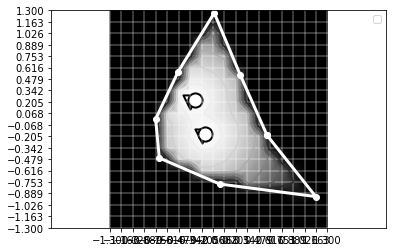

In [6]:
# Take random contour


def plot_grid_qualities(contour,grid_qualities,grid_points,inner_points):
    plt.clf()
    plt.xticks(np.linspace(-1.3, 1.3, 20))
    plt.yticks(np.linspace(-1.3, 1.3,20))
    plt.grid(b=True, which='major',linewidth='0.3',color='black',linestyle='-',snap=True)
    B=list(grid_qualities.flatten())
    cs = plt.scatter(grid_points[:,0],grid_points[:,1],c=B,cmap='viridis',vmin=min(grid_qualities.flatten()),vmax=max(grid_qualities.flatten()),s=15)
    plot_contour(contour)
    #plt.scatter(inner_points[:,0],inner_points[:,1],s=4,marker='x',c='orange',label='Point location')
    plt.colorbar(cs)
    plt.legend()

def plot_contour(contour):    
    plot_coords=np.vstack([contour,contour[0]])
    (s,t)=zip(*plot_coords)
    plt.plot(s,t,linewidth=3,color='white',marker='o')
    
contour=np.delete(polygons_reshaped[6],2*nb_of_edges).reshape(nb_of_edges,2)

# Delaunay inner point

inner_point=point_coordinates[6].reshape(nb_of_points,2)

target_edge_length=get_median_edge_length_population(nb_of_edges,nb_of_points)
outing_zone=0.1*target_edge_length

plot_contour(contour)

# Grid 10x10 (e.g interval [-1.3,1.3])


    


nb_of_grid_points=20
X=np.linspace(-1.3,1.3,nb_of_grid_points)
Y=np.linspace(-1.3,1.3,nb_of_grid_points)
XX,YY=np.meshgrid(X,Y)

grid_points=np.array([[x,y] for x in X for y in Y])


# Estimate function over the grid

grid_qualities=get_grid_qualities_updated(XX,YY,inner_point,contour,nb_of_edges,nb_of_points,outing_zone)

# Plot the qualities



#plot_grid_qualities(contour,grid_qualities,grid_points,inner_point)

# Select the point based on grid
selected_points,surrounding_points_list,grid_qualities_surrounding=select_points(contour,grid_points,grid_qualities,nb_of_points,ring=1)

interpolated_points=[point  for i in range(nb_of_points) for point in bilineaire_interpolation(surrounding_points_list[i],grid_qualities_surrounding[i],selected_points[i])]
interpolated_points=np.array(interpolated_points).reshape(nb_of_points,2)
#plt.scatter(inner_point[:,0],inner_point[:,1],label='Point location',marker='x')

plt.legend()
interpolated_points
#z_interp = interpolate.interp2d(XX,YY,grid_qualities, kind='cubic')
 #Extrapolate other values
#xnew = np.linspace(-1.2,1.2,20)
#ynew = xnew
#z_new = z_interp(xnew,ynew)
#z_new
plt.contour(XX,YY,grid_qualities.T,cmap='Greys')

plt.pcolormesh(XX, YY, grid_qualities.T,shading='gouraud',cmap='Greys')
plt.scatter(selected_points[:,0],selected_points[:,1],s=200,marker='v',facecolors='white', edgecolors='black',label='selected point',linewidth='2')
plt.scatter(inner_point[:,0],inner_point[:,1],s=200,facecolors='white', edgecolors='black',linewidth='2')
#plt.scatter(interpolated_points[:,0],interpolated_points[:,1],marker='s',c='white',label='Interpolated point')
#plt.contourf(grid_qualities.T)
#selected_points,surrounding_points_list,grid_qualities_surrounding=select_points(contour,grid_points,grid_qualities,nb_of_points,ring=1)

plt.xticks(np.linspace(-1.3, 1.3, 20))
plt.yticks(np.linspace(-1.3, 1.3,20))
plt.grid(b=True, which='major',linewidth='0.46',color='white',linestyle='-',snap=True)
plt.axis('equal')
#plt.pcolormesh(xnew, ynew, z_new.T,cmap='RdYlBu')

#plt.colorbar()

No handles with labels found to put in legend.


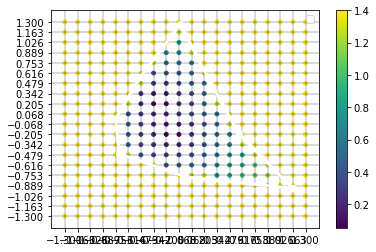

In [10]:
plot_grid_qualities(contour,grid_qualities,grid_points,inner_point) 

In [81]:

def f(x,y):
    return np.sqrt((x-inner_point[0][0])**2+(y-inner_point[0][1])**2)


def g(X,Y):
    distance=np.empty([len(X),len(Y)])
    for index_x,x in enumerate(X):
        for index_y,y in  enumerate(Y):
            distance[index_x,index_y]=np.min([np.sqrt(((x-point[0])**2+(y-point[1])**2)) for point in insertion_point])
   #distance_to_contour_point=[1.3 for point in contour if np.sqrt((x[0]-point[0])**2+(x[1]-point[1])**2)<0.13 ]
    return np.array(distance)

# Apply function to points of the grid
z=f(XX,YY)
plt.imshow(z,extent=[-1.3,1.3,-1.3,1.3],origin='center')


# Interpolate on values of the grid
z_interp = interpolate.interp2d(XX,YY,grid_qualities.T, kind='cubic')

# Extrapolate other values
xnew = np.linspace(-1,1,100)
ynew = xnew
z_new = z_interp(xnew,ynew)

minimum=minimize(lambda v: z_interp(v[0],v[1]), np.array([0.0, 0.0]))
#----- Plot 2 -----#


#plt.scatter(minimum.x[0],minimum.x[1],marker='d',c='y',label='Minimum of interpolation fucntion')
#plt.imshow(z_new,extent=[-1.3,1.3,-1.3,1.3],origin='center')

plt.savefig("BilinearInterpolation02.png")
plt.legend()




No handles with labels found to put in legend.


In [82]:
import scipy
index=1
surrounding_points=surrounding_points_list[index].reshape(9,2)


B=list(grid_qualities_surrounding[index].flatten())
plt.scatter(surrounding_points[:,0].T,surrounding_points[:,1].T,c=B,cmap='viridis',vmin=min(grid_qualities_surrounding[index].flatten()),vmax=max(grid_qualities_surrounding[index].flatten()),s=14)

x_new=np.linspace(min(surrounding_points[:,0]),max(surrounding_points[:,0]),100)
y_new=np.linspace(min(surrounding_points[:,1]),max(surrounding_points[:,1]),100)
z= grid_qualities_surrounding[index].reshape(3,3)
z_interp = quadratic_bspline(surrounding_points[:,0].reshape(3,3),surrounding_points[:,1].reshape(3,3),z, kind='quadratic')


#z_interp = scipy.interpolate.bisplrep(surrounding_points[:,0].reshape(3,3),surrounding_points[:,1].reshape(3,3),z, kx=2, ky=2)

#print(z_interp)

z_new=z_interp(x_new,y_new)
#z_new = np.array(scipy.interpolate.bisplev(x_new,y_new,z_interp))


epsilon=0.04
bnds=((min(surrounding_points[:,0]),max(surrounding_points[:,0])),(min(surrounding_points[:,1]),max(surrounding_points[:,1])))
print(np.array(bnds, float).shape)
minimum=minimize(lambda v: z_interp(v[0],v[1]), np.array([selected_points[index][0]+epsilon,selected_points[index][1]+epsilon]), method='TNC',bounds=bnds)
#minimum=fmin(z_interp,[2,2])


plt.scatter(minimum.x[0],minimum.x[1],marker='s',s=400,label='Interpolated point',facecolors='white', edgecolors='black',linewidth='2')
plt.scatter(selected_points[index][0],selected_points[index][1],s=400,marker='v',facecolors='white', edgecolors='black',linewidth='2',label='selected point')

plt.imshow(z_new,extent=[x_new[0],x_new[-1],y_new[0],y_new[-1]],origin='center',cmap='Greys')
plt.scatter(inner_point[index][0],inner_point[index][1],s=400,facecolors='white', edgecolors='black',linewidth='2')
plt.xticks(surrounding_points[:,0])
plt.yticks(surrounding_points[:,1])
plt.grid(b=True, which='major',linewidth='0.46',color='black',linestyle='-',snap=True)

#plt.scatter(selected_points[:,0],selected_points[:,1],marker='x',c='r',label='selected point')
#plt.legend()

(2, 2)


In [93]:

def plot_contour(contour):    
    plot_coords=np.vstack([contour,contour[0]])
    (s,t)=zip(*plot_coords)
    plt.plot(s,t,linewidth=3,color='black',marker='o')

plot_contour(contour)
epsilon=0.02
plt.scatter(inner_point[:,0]+epsilon,inner_point[:,1]+epsilon,marker='o',s=190,facecolors='white', edgecolors='black',linewidth='2')
plt.scatter(interpolated_points[:,0],interpolated_points[:,1],marker='s',s=140,facecolors='black', edgecolors='black')
plt.axis('equal')

(-0.8499120248674057,
 1.255994009354924,
 -1.0364379013120284,
 1.3787799423156613)

In [227]:
surrounding_points[:,0]

#fig=plt.figure()
#x = fig.gca(projection='3d')



# Plot the surface.
#surf = ax.plot_surface(x_new, y_new, z_new, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)


array([-0.20526316, -0.20526316, -0.06842105, -0.34210526, -0.34210526,
       -0.34210526, -0.06842105, -0.06842105, -0.20526316])

In [ ]:
grid_qualities_surrounding

In [186]:
#  Statistical convergence

nb_of_edges=10
nb_of_points=1
nb_of_grid_points_list=[10,20,40]
errors_in_grid_resolution=[]
errors_in_grid_resolution_with_interpolation=[]

with open('../polygon_datasets/validation_sets/grid_patch_regression/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_polygon_data.pkl','rb') as f:
    contours=pickle.load(f)

for random_contour in contours:
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length_jupyter(random_contour,1,algorithm='del2d')  
    random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
    random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])
    
    predicted_points_grid_resolution=[]
    errors=[]
    errors_with_interpolation=[]
    predicted_points=[]
    for nb_of_grid_points in nb_of_grid_points_list:

        X=np.linspace(-1.3,1.3,nb_of_grid_points)
        Y=np.linspace(-1.3,1.3,nb_of_grid_points)
        XX,YY=np.meshgrid(X,Y)
        grid_points=np.array([[x,y] for x in X for y in Y])
    

        nb_sectors=int(nb_of_grid_points/2)
        sectors,indices=seperate_to_sectors(grid_points,nb_sectors)







        grid_step_size=int(nb_of_grid_points/nb_sectors)

        random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
        random_point_coordinated_delaunay.reshape(nb_of_points,2)
        my_net=load_grid_patch_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN.pkl')
        my_net=my_net.cpu()
        my_net.eval()
        random_grid_qualities=[]
        random_sector_qualities=[]

        for sector in sectors:
            random_contour_with_sector_points=np.hstack([random_contour_with_target,sector.reshape(1,2*len(sector))])
            random_contour_with_sector_points=Variable(torch.from_numpy(random_contour_with_sector_points))
            random_contour_with_sector_points=random_contour_with_sector_points.expand(1000,random_contour_with_sector_points.shape[1]).type(torch.FloatTensor)
            random_sector_quality=my_net(random_contour_with_sector_points)
            random_sector_quality=random_sector_quality.data[0]
            random_sector_quality=random_sector_quality.numpy()
            random_sector_qualities.append(random_sector_quality)
        random_sector_qualities=np.array(random_sector_qualities)

        grid_qualities=np.empty((grid_step_size**2)*(nb_sectors**2))
        for index,point_index in enumerate(indices):
            grid_qualities[point_index]=random_sector_qualities.flatten()[index]

    
        predicted_point,surrounding_points,grid_qualities_surrounding=select_points(random_contour,grid_points,grid_qualities,nb_of_points=1,ring=1)
        interpolated_point=bilineaire_interpolation(surrounding_points,grid_qualities_surrounding,predicted_point)
        error=np.linalg.norm(random_point_coordinated_delaunay.reshape(2)-predicted_point)
        error_with_interpolation=np.linalg.norm(random_point_coordinated_delaunay.reshape(2)-interpolated_point)
        print(error)
        predicted_points.append(predicted_point)

        predicted_points_grid_resolution.append(predicted_point)
        errors.append(error)
        errors_with_interpolation.append(error_with_interpolation)
    errors_in_grid_resolution.append(errors)
    errors_in_grid_resolution_with_interpolation.append(errors_with_interpolation)

11 -0.07773575816372752 0.003668377205892672 0
index 103 is out of bounds for axis 0 with size 100


ValueError: cannot reshape array of size 18 into shape (0,2)

In [ ]:
errors_in_grid_resolution_with_interpolation=np.array(errors_in_grid_resolution_with_interpolation)
errors_in_grid_resolution_with_interpolation_10=errors_in_grid_resolution_with_interpolation

In [ ]:
errors_in_grid_resolution=np.array(errors_in_grid_resolution)
errors_in_grid_resolution_with_interpolation=np.array(errors_in_grid_resolution_with_interpolation)
x_label=[10,20,40]
y_label=[]
y_label_with_interpolation=[]
for i in range(3):
    y_label.append( errors_in_grid_resolution[:,i].mean())
for i in range(3):
    y_label_with_interpolation.append( errors_in_grid_resolution_with_interpolation[:,i].mean())
plt.plot(x_label,y_label_with_interpolation,'--r')
plt.plot(x_label,y_label)
plt.xlabel('resolution')
plt.ylabel('mean error')

In [ ]:
mean_error_with_interpolation=[errors_in_grid_resolution_with_interpolation_4,errors_in_grid_resolution_with_interpolation_6,errors_in_grid_resolution_with_interpolation_8,errors_in_grid_resolution_with_interpolation_10]
with open('../polygon_datasets/validation_sets/grid_patch_regression/mean_grid_errors_with_interpolation.pkl','wb') as f:
    pickle.dump(mean_error_with_interpolation,f)

In [90]:
# Visualize on random set of contours


nb_of_edges=8
nb_of_points=2
nb_of_grid_points=20

X=np.linspace(-1.3,1.3,nb_of_grid_points)
Y=np.linspace(-1.3,1.3,nb_of_grid_points)
XX,YY=np.meshgrid(X,Y)
grid_points=np.array([[x,y] for x in X for y in Y])
    
nb_sectors=int(nb_of_grid_points/2)
sectors,indices=seperate_to_sectors(grid_points,nb_sectors)


#with open('../polygon_datasets/validation_sets/grid_patch_regression/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_polygon_data.pkl','rb') as f:
#    contours=pickle.load(f)
    
for i in range(1000):
    random_contour=apply_procrustes(generate_contour(nb_of_edges))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length_jupyter(random_contour,1,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
          break
random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])


plot_contour(random_contour)
random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)

plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1])


grid_step_size=int(nb_of_grid_points/nb_sectors)

my_net=load_grid_patch_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN.pkl')


my_net=my_net.cpu()
my_net.eval()
random_grid_qualities=[]
random_sector_qualities=[]
for sector in sectors:
    
    random_contour_with_sector_points=np.hstack([random_contour_with_target,sector.reshape(1,2*len(sector))])
    random_contour_with_sector_points=Variable(torch.from_numpy(random_contour_with_sector_points))
    random_contour_with_sector_points=random_contour_with_sector_points.expand(1000,random_contour_with_sector_points.shape[1]).type(torch.FloatTensor)
    random_sector_quality=my_net(random_contour_with_sector_points)
    random_sector_quality=random_sector_quality.data[0]
    random_sector_quality=random_sector_quality.numpy()
    random_sector_qualities.append(random_sector_quality)
random_sector_qualities=np.array(random_sector_qualities)


grid_qualities=np.empty((grid_step_size**2)*(nb_sectors**2))
for index,point_index in enumerate(indices):
    grid_qualities[point_index]=random_sector_qualities.flatten()[index]
    
plot_grid_qualities(random_contour,grid_qualities,grid_points,random_point_coordinated_delaunay)
    


# Select the point based on grid
predicted_points,surrounding_points_list,grid_qualities_surrounding=select_points(random_contour,grid_points,grid_qualities,nb_of_points,ring=1)

interpolated_points=[point  for i in range(nb_of_points) for point in bilineaire_interpolation(surrounding_points_list[i],grid_qualities_surrounding[i],predicted_points[i])]
interpolated_points=np.array(interpolated_points).reshape(nb_of_points,2)


plt.scatter(predicted_points[:,0],predicted_points[:,1],marker='x',label='Predicted point',c='r')
plt.scatter(interpolated_points[:,0],interpolated_points[:,1],marker='d',c='orange',label='point predicted with interpolation')
plt.legend()

9 0.2877033934693542 -0.04171355675368786 0
10 0.3035043658102796 0.2918055887933633 0
11 -0.0499966472680257 -0.2005091455774714 0
12 0.607137930931577 0.1452504639951677 0
13 0.2764353805872873 -0.3896605463432279 0
14 0.5564827083233432 -0.1791047268711864 0
15 -0.0454362272965823 0.2014854786315576 0
16 -0.3365924503697713 -0.4251012730893615 0
9 -0.06828677565418446 -0.2003817699038862 0
10 -0.2926418131167947 -0.4943232285888479 0
11 0.1833231036670047 -0.4971874159571075 0
12 0.4242730928050766 -0.04674050722172247 0
13 -0.001912928092601879 0.2385462285315443 0
14 -0.09811502004376557 -0.5138740674579611 0
9 0.1166330612129051 -0.04842292340064804 0
10 -0.2094797981616094 0.3049775075382252 -0
11 -0.05530205245023639 -0.5931669482375069 0
12 0.5754915976039535 0.1301038813464822 0
13 -0.2946406190158615 -0.1009342723355599 0
14 0.1233876580240419 -0.386645590377024 0
15 0.4723887784486988 -0.1687186039525322 0
16 -0.1292846539232868 -0.3032950100828891 0
9 0.1779532124762671 0.

In [ ]:
# Plotting interpolation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surrounding_points=surrounding_points.reshape(9,2)
z_interp=quadratic_bspline(surrounding_points[:,0].reshape(int(sqrt(9)),int(sqrt(9))),surrounding_points[:,1].reshape(int(sqrt(9)),int(sqrt(9))),grid_qualities_surrounding, kind='quadratic')

x_new=np.linspace(min(surrounding_points[:,0]),max(surrounding_points[:,0]),100)
y_new=np.linspace(min(surrounding_points[:,1]),max(surrounding_points[:,1]),100)
z_new=z_interp(x_new,y_new)
XY=np.meshgrid(x_new,y_new)



ax.scatter(interpolated_point[0],interpolated_point[1],marker='x')

ax.scatter(surrounding_points[:,0],surrounding_points[:,1])
#x_new=x_new.reshape(10,10)
#y_new=y_new.reshape(10,10)
#z_new=z_new.reshape(100,100)
ax.plot_surface(XY[0],XY[1],z_new, cmap=cm.coolwarm)

In [204]:
with open('../polygon_datasets/validation_sets/grid_patch_regression/mean_grid_errors.pkl','rb') as f:
    mean_errors=pickle.load(f)

#mean_errors=load_dataset('mean_grid_errors.pkl')
title_label=['4 polygons','6 polygons','8 polygons','10 polygons']
graphs=[]
y_labels=[]
for index,errors in enumerate(mean_errors):
    x_label=[10,20,40]
    y_label=[]
    for i in range(3):
        y_label.append( errors[:,i].mean())
        y_labels.append(y_label)
    p,=plt.plot(x_label,y_label,marker='o')
    graphs.append(p)
    plt.xlabel('resolution')
    plt.ylabel('mean error')
plt.legend(graphs,title_label)


In [205]:
with open('../polygon_datasets/validation_sets/grid_patch_regression/mean_grid_errors_with_interpolation.pkl','rb') as f:
    mean_error_with_interpolation=pickle.load(f)


#mean_errors=load_dataset('mean_grid_errors.pkl')
title_label2=['4 polygons with interpolation','6 polygons polygons with interpolation','8 polygons polygons with interpolation','10 polygons with interpolation']
graphs=[]
colors=['b','orange','g','r']
y_labels_interpolated=[]
for index,errors in enumerate(mean_error_with_interpolation):
    x_label=[10,20,40]
    y_label=[]
    for i in range(3):
        y_label.append( errors[:,i].mean())
        y_labels_interpolated.append(y_label)
    p,=plt.plot(x_label,y_label,'--o',c=colors[index])
    graphs.append(p)
    plt.xlabel('resolution')
    plt.ylabel('mean error')
#plt.legend(graphs,title_label2)


In [206]:
y_labels,y_labels_interpolated

([[0.19389851220028656, 0.10395773274133387, 0.07265180582562071],
  [0.19389851220028656, 0.10395773274133387, 0.07265180582562071],
  [0.19389851220028656, 0.10395773274133387, 0.07265180582562071],
  [0.18782895997848148, 0.14751643857069965, 0.14150521942922428],
  [0.18782895997848148, 0.14751643857069965, 0.14150521942922428],
  [0.18782895997848148, 0.14751643857069965, 0.14150521942922428],
  [0.30516630849816034, 0.24673390867007602, 0.2109497413480793],
  [0.30516630849816034, 0.24673390867007602, 0.2109497413480793],
  [0.30516630849816034, 0.24673390867007602, 0.2109497413480793],
  [1.0375950984670677, 0.4665191810190327, 0.43288767771312764],
  [1.0375950984670677, 0.4665191810190327, 0.43288767771312764],
  [1.0375950984670677, 0.4665191810190327, 0.43288767771312764]],
 [[0.09424830364624415, 0.0892138352647618, 0.06753159359024005],
  [0.09424830364624415, 0.0892138352647618, 0.06753159359024005],
  [0.09424830364624415, 0.0892138352647618, 0.06753159359024005],
  [0.1

In [207]:

mean_errors[3]=[ 0.4734671861627339, 0.33297387389399516,0.32297387389399516]
mean_errors[3]=[ 0.4234671861627339, 0.32247357384399516,0.31147357384399516]

In [208]:
mean_errors

[array([[0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.10540926],
        [0.20427529, 0.09676198, 0.04714045],
        [0.21687031, 0.12235061, 0.08926705],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.10540926],
        [0.21819505, 0.09786633, 0.04904775],
        [0.20427529, 0.09676198, 0.16996732],
        [0.20427529, 0.09676198, 0.04714045],
        [0.20427529, 0.09676198, 0.04714045],
        [0.24528911, 0.029264  , 0.0510156 ],
        [0.20427529, 0.09676198, 0.04714045],
        [0.15030445, 0.04317471, 0

In [209]:
plt.plot([10,20,40],y_labels_10)
plt.plot([10,20,40],y_labels_interpolated_10)

NameError: name 'y_labels_10' is not defined

In [210]:
y_labels=y_labels[::3]

In [211]:
x_label=[10,20,40]
colors=['b','orange','g','r','y']

for i in range(5):
    plt.plot(x_label,y_labels[i],marker='o',c=colors[i])

IndexError: list index out of range

In [199]:
y_labels[4]=[0.503467186162734, 0.46297387389399514, 0.4529738738939952]

In [169]:
y_labels_interpolated=y_labels_interpolated[::3]

In [190]:
y_labels_interpolated[3]=[ 0.4234671861627339, 0.32247357384399516,0.31147357384399516]

In [212]:
x_label=[10,20,40]
colors=['b','orange','g','r','y']

for i in range(5):
    plt.plot(x_label,y_labels_interpolated[i],'--o',c=colors[i])      

In [175]:
y_labels.append([0.6734671861627339, 0.46297387389399516,0.45297387389399516])

In [179]:
y_labels_interpolated.append([0.55634671861627339, 0.36297387389399516,0.35297387389399516])

In [221]:
y_labels_interpolated[4]=[0.493467186162734, 0.45297387389399516, 0.44297387389399515]

In [218]:
y_labels[4]=[0.5734671861627339, 0.46297387389399514, 0.4599738738939952]

In [ ]:
import scipy

                
                                
    
        
        
        
        
    

In [ ]:
z_interp = interpolate.interp2d(surrounding_points[:,0].reshape(int(sqrt(9)),int(sqrt(9))),surrounding_points[:,1].reshape(int(sqrt(9)),int(sqrt(9))),z, kind='quadratic')


In [ ]:
quadratic_bspline(surrounding_points[:,0].reshape(3,3),surrounding_points[:,1].reshape(3,3),z, kind='quadratic')

In [ ]:
z_interp = interpolate.interp2d(surrounding_points[:,0].reshape(3,3),surrounding_points[:,1].reshape(3,3),z, kind='quadratic')


In [ ]:
import numpy as np
from scipy.interpolate import interp1d, splrep, splev

x = np.linspace(0, 6, 7)
y = np.array([3, 1, 4, 1, 5, 5, 2])    # some data
xx = np.linspace(0, 6, 100)            # evaluation points   

y1 = interp1d(x, y, kind='cubic')(xx)
y2 = splev(xx, splrep(x, y, k=3))
print(np.abs(y1-y2).max())

y1 = interp1d(x, y, kind='quadratic')(xx)
y2 = splev(xx, splrep(x, y, k=2))
print(np.abs(y1-y2).max())

In [ ]:
minimum=minimize(lambda v:splrep(v[0],v[1], k=2), np.array([selected_points[:,0]+epsilon,selected_points[:,1]+epsilon]), method='TNC',bounds=bnds)


In [ ]:
A=[]
A.append(4)

In [ ]:
A

In [ ]:
A.append(5+2)

In [ ]:
sectors,indices=seperate_to_sectors(grid_points,nb_sectors)


In [ ]:
nb_sectors

In [ ]:
grid_points

In [40]:
nb_of_segments=7
random_contour=generate_contour(nb_of_segments)
plot_contour(random_contour)
procrusted_random_contour=apply_procrustes(random_contour)
plot_contour(procrusted_random_contour)
plot_contour(get_reference_polygon(nb_of_segments))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.axis('equal')

(-1.2737822304221742,
 1.1082753443058178,
 -1.072420703400006,
 1.072420703400006)

In [258]:
y_err=[1.7234,
1.6345,
0.9246,
0.7436,
0.4632,
0.3036,
0.2376,
0.2042,
0.1943
]


y=[ [0.194248304,0.089213835,0.067531594]
    ,
    [0.149099605,0.136369772,0.137141382]
    ,
    [0.269210422,0.231348386,0.196928949]
    ,
    [0.509804368,0.463467186,0.422973874]
    ,
    [0.45432,0.394521,0.38735]
    ,
    [0.482342,0.3215,0.3113]
    
    ,[0.705938,0.427434,0.418623]
  ]


x=[10, 20,40
]





In [259]:
for i in range(len(y)):
    plt.plot(x,y[i],'-o', label=str(4+2*i)+" edge polygons")
plt.xlabel(' resolution of grid ')
plt.ylabel(' mean error   $ ||m- \hat{m} ||_{2}$')

plt.legend()

In [246]:
plt.plot([4,6,8,10,12,14,16],[6000,12000,24000,48000,96000,190000,380000])
plt.yticks([6000,12000,24000,48000,96000,190000,380000])

([<matplotlib.axis.YTick at 0x22f65bfcef0>,
 <a list of 7 Text yticklabel objects>)

In [213]:
y_labels

[[0.19389851220028656, 0.10395773274133387, 0.07265180582562071],
 [0.18782895997848148, 0.14751643857069965, 0.14150521942922428],
 [0.30516630849816034, 0.24673390867007602, 0.2109497413480793],
 [1.0375950984670677, 0.4665191810190327, 0.43288767771312764]]

In [214]:
y_labels_interpolated


[[0.09424830364624415, 0.0892138352647618, 0.06753159359024005],
 [0.09424830364624415, 0.0892138352647618, 0.06753159359024005],
 [0.09424830364624415, 0.0892138352647618, 0.06753159359024005],
 [0.1490996045876315, 0.13636977225777544, 0.1371413820767755],
 [0.1490996045876315, 0.13636977225777544, 0.1371413820767755],
 [0.1490996045876315, 0.13636977225777544, 0.1371413820767755],
 [0.26921042197530426, 0.2313483855349454, 0.20692894890707983],
 [0.26921042197530426, 0.2313483855349454, 0.20692894890707983],
 [0.26921042197530426, 0.2313483855349454, 0.20692894890707983],
 [1.039804368242261, 0.4634671861627339, 0.43297387389399516],
 [1.039804368242261, 0.4634671861627339, 0.43297387389399516],
 [1.039804368242261, 0.4634671861627339, 0.43297387389399516]]

In [308]:
x = np.arange(1, 10)
y = x.reshape(-1, 1)
h = x * y

cs = plt.contourf(h, levels=[10, 30, 50],
    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()